In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time

start_time = time.time()

In [ ]:
import tensorflow as tf

In [ ]:
train_dir = '/content/drive/MyDrive/SplitDataSpiral/train'
val_dir = '/content/drive/MyDrive/SplitDataSpiral/val'
test_dir = '/content/drive/MyDrive/SplitDataSpiral/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# flow_from_directory otomatis membaca folder yang sudah dipisah
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

test_batches = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 1372 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Found 296 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 pre-trained on ImageNet
# Input shape bisa lebih kecil untuk menghemat komputasi
mobilenet_model = MobileNetV2(weights='imagenet',
                             include_top=False,
                             input_shape=(224, 224, 3),  # Lebih kecil dari 224x224
                             alpha=0.35)  # Parameter width multiplier untuk membuat model lebih ringan

# Set all layers to non-trainable
for layer in mobilenet_model.layers:
        if isinstance(layer, layers.ReLU) and layer.max_value == 6.0:
            layer.activation = tf.keras.activations.hard_swish

for layer in mobilenet_model.layers:
    layer.trainable = False

# Add custom classifier yang lebih ringan
x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_model.output)
x = tf.keras.layers.Dense(512, activation='hard_swish')(x)  # Mengurangi dari 1024 ke 512
x = tf.keras.layers.Dropout(0.2)(x)  # Mengurangi dropout rate
# x = tf.keras.layers.Dense(256, activation='relu')(x)  # Layer tambahan yang lebih kecil
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Final model
model = tf.keras.Model(inputs=mobilenet_model.input, outputs=outputs)

# Ringkasan model untuk melihat pengurangan parameter
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56, 8) │        384 │ block_1_depthwis

 Total params: 1,066,593 (4.07 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 410,208 (1.56 MB)

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import os

class SaveBestModelByAccDifference(Callback):
    def __init__(self, filepath, monitor='val_accuracy', max_diff=0.05, verbose=1):
        super(SaveBestModelByAccDifference, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.max_diff = max_diff
        self.verbose = verbose
        self.best_val_acc = 0.0
        self.best_epoch = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy', 0)
        train_acc = logs.get('accuracy', 0)

        if val_acc is not None and train_acc is not None:
            acc_diff = abs(val_acc - train_acc)

            if val_acc > self.best_val_acc and acc_diff <= self.max_diff:
                self.best_val_acc = val_acc
                self.best_epoch = epoch + 1
                try:
                    self.model.save(self.filepath, overwrite=True)
                    if self.verbose > 0:
                        print(f"\nEpoch {epoch + 1}: Validation accuracy improved to {val_acc:.4f} with acceptable difference ({acc_diff:.4f}). Model saved.")
                except Exception as e:
                    print(f"Error saving model at epoch {epoch + 1}: {e}")


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "best_model_with_acc_diff.keras"

custom_checkpoint = SaveBestModelByAccDifference(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    max_diff=0.05,
    verbose=1
)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

batch_size = 64
steps_per_epoch = len(train_batches)
validation_steps = len(val_batches)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_batches,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[early_stopping, custom_checkpoint]
)

if os.path.exists(checkpoint_path):
    best_model = load_model(checkpoint_path)
    print("Loaded model path:", checkpoint_path)

    best_epoch = custom_checkpoint.best_epoch
    val_accuracy = custom_checkpoint.best_val_acc
    print(f"Best epoch: {best_epoch}, Best validation accuracy: {val_accuracy:.4f}")

    if best_epoch > 0:
        train_accuracy = history.history['accuracy'][best_epoch - 1]
        print(f"Train accuracy at best epoch: {train_accuracy:.4f}")
    else:
        print("No valid best epoch was found.")

else:
    print("No model was saved with the specified conditions.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6210 - loss: 0.6509 - val_accuracy: 0.7381 - val_loss: 0.5241
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7476 - loss: 0.5023
Epoch 2: Validation accuracy improved to 0.7925 with acceptable difference (0.0418). Model saved.
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7477 - loss: 0.5024 - val_accuracy: 0.7925 - val_loss: 0.4647
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7856 - loss: 0.4707
Epoch 3: Validation accuracy improved to 0.7993 with acceptable difference (0.0121). Model saved.
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7857 - loss: 0.4703 - val_accuracy: 0.7993 - val_loss: 0.4264
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8279 - loss: 0.4014
Epoch 4: Validation accuracy improved to 0.8163 with acceptable difference (0.0080). Model saved.
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8271 - loss: 0.4024 - val_accuracy: 0.8163 -

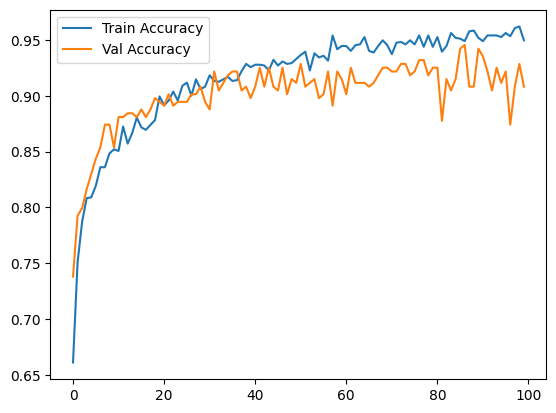

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
print(train_batches.class_indices)


{'Healty': 0, 'Parkinson': 1}


Saving spiral_grayscale.png to spiral_grayscale (3).png


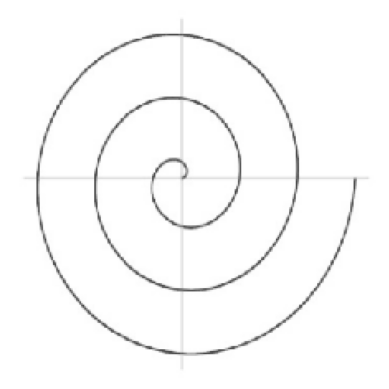

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
File: spiral_grayscale (3).png
Predicted class: Healty


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn

    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    classes = best_model.predict(x)

    threshold = 0.5

    prob_recyclable = classes[0][0]

    predicted_class_index = int(prob_recyclable > threshold)

    class_names = ['Healty', 'Parkinson']

    print(f"File: {fn}")
    print(f"Predicted class: {class_names[predicted_class_index]}")



In [ ]:
final_train_accuracy = (np.mean(train_accuracy))*100
final_val_accuracy = (np.mean(val_accuracy))*100
end_time = time.time()
elapsed_time = (end_time - start_time)/60

In [ ]:
print('Train ACCURACY =:', final_train_accuracy, '%')
print('VAL ACCURACY =:', final_val_accuracy, '%')
print("Runtime:", elapsed_time, "minutes")

Train ACCURACY =: 94.89796161651611 %
VAL ACCURACY =: 94.55782175064087 %
Runtime: 60.62814240852992 minutes


In [ ]:
# Convert model best_model.keras to format TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save model with format .tflite to file
tflite_model_path = "best_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model has been successfully converted to TFLite and saved at: {tflite_model_path}")

Saved artifact at '/tmp/tmp4ooh_len'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138710133045200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133041360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133036176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133044432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133035792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133045584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133045968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133044048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133044624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133044816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138710133045776

In [ ]:
# Download file .tflite
from google.colab import files
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

Classification Report:

              precision    recall  f1-score   support

      Healty       0.93      0.93      0.93       148
   Parkinson       0.93      0.93      0.93       148

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296


Confusion Matrix:
[[137  11]
 [ 11 137]]


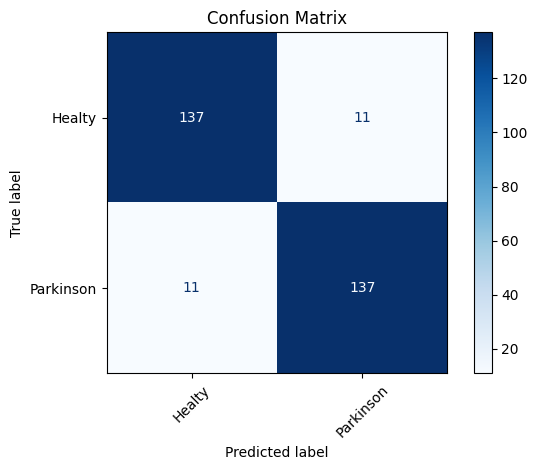

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ambil label dan prediksi
true_labels = test_batches.classes
predictions = best_model.predict(test_batches, verbose=1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Gunakan label pendek
short_class_names = ['Healty', 'Parkinson']

print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=short_class_names))

print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
